In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow.python.framework import ops

tf.logging.set_verbosity(tf.logging.INFO)

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
#define the network's architecture

net_arch = {
    "input_layer": {
        "num_px": 128,
        "num_c": 3
    }, #128,128,3

    "conv1": {
        "filters": 8,
        "kernel_size": [6,6]
    }, #128,128,8

    "pool1": {
        "pool_size": [5,5],
        "strides": 4
    }, #32,32,8

    "conv2": {
        "filters": 16,
        "kernel_size": [3,3]
    }, #32,32,16

    "pool2": {
        "pool_size": [5,5],
        "strides": 4
    }, #8,8,16

    "conv3": {
        "filters": 32,
        "kernel_size": [3,3]
    }, #8,8,32

    "pool3": {
        "pool_size": [5,5],
        "strides": 4
    }, #2,2,32       

    "dense": {
        "units": 64
    },

    "dropout": {
        "rate": 0.2
    },

    "logits": {
        "units": 2
    }
}

In [3]:
params = {
    #load the model from a pre trained model directory
    #it has been trained on all 25000 images with a train test split of 0.95/0.05 on google cloud
    #it will not be further trained in this notebook
    #the total batch size is thus only for demonstrating the accuracy
    #evaluate on "train_set" with 4500 images
    "MODEL_DIR": "cnn_model",
    
    "input_data": {
        "total_batch_size": 5000,
        "tt_split": 0.9,
        "num_px": net_arch["input_layer"]["num_px"] 
    },    
    #not being used here
    "train": {
        "steps": 2000,
        "batch_size": 128,
        "shuffle": True
    },
    
    "warm_start": {
        "flag_warm_start": True,
        "warm_start_dir": "cnn_model"
    },
    
    "optimizer": {
        "learning_rate": 0.00004,
        "decay_steps": 500,
        "decay_rate": 0.95
    },
    
    "logging": {
        "every_n_iter": 10,
        "save_summary_steps": 10,
        "flag_image": True,
        "num_img": 3,
        "num_conv1_chan": 1,
        "num_conv2_chan": 1
    },

    "arch": net_arch
}


In [4]:
def load_images(num_img,num_px,tt_split=0.9):

    
    temp_image_set=[]
    
    num_cat_dog = num_img // 2

    for i in np.random.permutation(12500)[:num_cat_dog]:
        image_temp=Image.open("train/cat." + str(i) + ".jpg")
        temp_image_set.append(np.asarray(image_temp.resize((num_px,num_px))))
        
    for i in np.random.permutation(12500)[:num_cat_dog]:
        image_temp=Image.open("train/dog." + str(i) + ".jpg")
        temp_image_set.append(np.asarray(image_temp.resize((num_px,num_px))))

    
    image_set=np.stack(temp_image_set)
    label_set=np.append(np.zeros((1,num_cat_dog)).T,np.ones((1,num_cat_dog)).T,axis=0) #cat=0, dog=1
       
    indices = np.random.permutation(num_img)   
    train_num = int(tt_split*num_img)
    
    train_idx, eval_idx = indices[:train_num], indices[train_num:]
    
    train_data, eval_data = image_set[train_idx,:,:,:], image_set[eval_idx,:,:,:]
    train_labels, eval_labels = label_set[train_idx,:], label_set[eval_idx,:]
    
    return train_data, train_labels, eval_data, eval_labels

In [5]:
#scale the input data 

def transform_data(train_data_orig, train_labels_orig, eval_data_orig, eval_labels_orig):

    train_data_flat = train_data_orig.reshape((-1,np.prod(train_data_orig.shape[1:])))
    eval_data_flat = eval_data_orig.reshape((-1,np.prod(eval_data_orig.shape[1:])))

    scaler = StandardScaler() 

    _ = scaler.fit(train_data_flat)

    train_data=scaler.transform(train_data_flat).reshape(train_data_orig.shape)
    eval_data=scaler.transform(eval_data_flat).reshape(eval_data_orig.shape)

    train_labels = train_labels_orig.flatten() 
    eval_labels = eval_labels_orig.flatten() 

    return train_data, train_labels, eval_data, eval_labels

In [6]:
#forward  propagation of the network
#the explicit architecture is defined in net_arch below

def forward_fn(features, labels, mode, params):
    
    input_layer = tf.reshape(features["x"], [-1, params["arch"]["input_layer"]["num_px"], params["arch"]["input_layer"]["num_px"], params["arch"]["input_layer"]["num_c"]])
    
    
    if params["logging"]["flag_image"]:
        tf.summary.image(name = "image_0input", tensor = input_layer[:,:,:,:3], max_outputs = params["logging"]["num_img"])
    
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=params["arch"]["conv1"]["filters"],
        kernel_size=params["arch"]["conv1"]["kernel_size"],
        kernel_initializer = tf.contrib.layers.xavier_initializer(seed = 42),
        bias_initializer = tf.zeros_initializer(),
        padding="same",
        activation=tf.nn.relu)
    
    if params["logging"]["flag_image"]:
        for i_c in range(min(params["arch"]["conv1"]["filters"],params["logging"]["num_conv1_chan"])):
            tf.summary.image(name = "image_conv1", tensor = conv1[:,:,:,i_c:i_c+1], max_outputs = params["logging"]["num_img"])


    pool1 = tf.layers.max_pooling2d(
        inputs=conv1,
        pool_size=params["arch"]["pool1"]["pool_size"],
        strides=params["arch"]["pool1"]["strides"],
        padding="same")
    

    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=params["arch"]["conv2"]["filters"],
        kernel_size=params["arch"]["conv2"]["kernel_size"],
        kernel_initializer = tf.contrib.layers.xavier_initializer(seed = 43),
        bias_initializer = tf.zeros_initializer(),
        padding="same",
        activation=tf.nn.relu)
    
    if params["logging"]["flag_image"]:
        for i_c in range(min(params["arch"]["conv2"]["filters"],params["logging"]["num_conv2_chan"])):
            tf.summary.image(name = "image_conv2", tensor = conv2[:,:,:,i_c:i_c+1], max_outputs = params["logging"]["num_img"])
    
    
    pool2 = tf.layers.max_pooling2d(
        inputs=conv2,
        pool_size=params["arch"]["pool2"]["pool_size"],
        strides=params["arch"]["pool2"]["strides"],
        padding="same")
   
    
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=params["arch"]["conv3"]["filters"],
        kernel_size=params["arch"]["conv3"]["kernel_size"],
        kernel_initializer = tf.contrib.layers.xavier_initializer(seed = 44),
        bias_initializer = tf.zeros_initializer(),
        padding="same",
        activation=tf.nn.relu)


    pool3 = tf.layers.max_pooling2d(
        inputs=conv3,
        pool_size=params["arch"]["pool3"]["pool_size"],
        strides=params["arch"]["pool3"]["strides"],
        padding="same")


    pool3_flat = tf.contrib.layers.flatten(pool3)


    dense = tf.layers.dense(
        inputs=pool3_flat,
        units=params["arch"]["dense"]["units"], 
        kernel_initializer = tf.contrib.layers.xavier_initializer(seed = 45),
        bias_initializer = tf.zeros_initializer(),
        activation=tf.nn.relu)

    dropout = tf.layers.dropout(
        inputs=dense, 
        rate=params["arch"]["dropout"]["rate"], 
        training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(
        inputs=dense,                      
        units=params["arch"]["logits"]["units"],
        kernel_initializer = tf.contrib.layers.xavier_initializer(seed = 46),
        bias_initializer = tf.zeros_initializer())

    return logits

In [7]:
def cnn_model_fn(features, labels, mode, params):
    
    logits = forward_fn(features, labels, mode, params)
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph for PREDICT
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=2)
    
    loss = tf.losses.softmax_cross_entropy(logits = logits, onehot_labels = onehot_labels)    

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        learning_rate = tf.train.exponential_decay(
            params["optimizer"]["learning_rate"],
            global_step = tf.train.get_global_step(),
            decay_steps = params["optimizer"]["decay_steps"],
            decay_rate = params["optimizer"]["decay_rate"])
        
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        
        #logs for terminal during training
        loss_log = tf.identity(loss, name = "loss_log")
        step_log = tf.identity(tf.train.get_global_step(), name = "step_log")
        learning_rate_log = tf.identity(learning_rate, name = "learning_rate_log")
    
        #summaries after training
        tf.summary.scalar("loss", loss) 
        
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    #if mode == tf.estimator.ModeKeys.EVAL:
    
    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [8]:
train_data_orig, train_labels_orig, eval_data_orig, eval_labels_orig = load_images(params["input_data"]["total_batch_size"],params["input_data"]["num_px"],tt_split=params["input_data"]["tt_split"])

train_data, train_labels, eval_data, eval_labels = transform_data(train_data_orig, train_labels_orig, eval_data_orig, eval_labels_orig)


/home/max/software/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/max/software/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/max/software/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
if params["warm_start"]["flag_warm_start"]:
    wss = tf.estimator.WarmStartSettings(ckpt_to_initialize_from = params["warm_start"]["warm_start_dir"])
else:
    wss = None
    
    
cat_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, 
    model_dir=params["MODEL_DIR"],
    config = tf.estimator.RunConfig(save_summary_steps = params["logging"]["save_summary_steps"]),
    params = params,
    warm_start_from=wss
)

        
    
    
# Set up logging for predictions
tensors_to_log = {
    "loss": "loss_log",
    "step": "step_log",
    "learning_rate": "learning_rate_log"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter = params["logging"]["every_n_iter"])

INFO:tensorflow:Using config: {'_model_dir': 'cnn_model', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6646c4b780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
#pre-trained network, not being further trained here

In [ ]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=params["train"]["batch_size"],
    num_epochs=None,
    shuffle=params["train"]["shuffle"])


In [ ]:
cat_classifier.train(
    input_fn=train_input_fn,
    steps=params["train"]["steps"],
    hooks=[logging_hook])

In [ ]:
#evaluate on train data set -> 83% accuracy

In [10]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    num_epochs=1,
    shuffle=False)
eval_results = cat_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-24T06:44:51Z
INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cnn_model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
predicted class and probabilities: [{'classes': 1, 'probabilities': array([0.19061325, 0.80938675])}]
actual class= 1.0


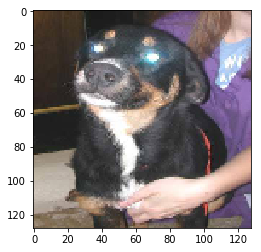

In [12]:
#explicit example
idx = 1

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data[idx]},
    shuffle=False)
predict_results = cat_classifier.predict(input_fn=predict_input_fn)

plt.imshow(eval_data_orig[idx])
print("predicted class and probabilities:",list(predict_results))
print("actual class=",eval_labels[idx])

